In [1]:

from datetime import datetime

import torch
from torch.utils.data import DataLoader

from datasets.LabeledImageDataset import LabeledImageDataset
from models.resnet import Resnet18BinaryClassifier, Resnet50BinaryClassifier, Resnet101BinaryClassifier
from train import train_classifier
from utils import plot_model_metrics
from utils import reduce_dataset, split_dataset, undersample_dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 256
dataset = LabeledImageDataset("data/candidates")
dataset = reduce_dataset(dataset, discard_ratio=0.0)
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.7)
# train_dataset = undersample_dataset(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, )

model = Resnet101BinaryClassifier( hidden_layers=1, units_per_layer=2048,
                      dropout=0.3, focal_alpha=0.9, focal_gamma=2.0)

print(f"Dataset: {len(train_dataset):,} training, {len(test_dataset):,} testing")


Device: cuda:0
Dataset: 9,479 training, 4,063 testing


In [2]:
print(model)

Resnet101BinaryClassifier(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

In [3]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2025-02-09T09:37:42.069513


In [4]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, test_loader, device,
                                        start_learning_rate=0.000075,
                                        max_epochs=5,
                                        checkpoint_every=1,
                                        eval_every=1)


Epoch 1 training:   5%|▌         | 2/38 [00:03<01:06,  1.85s/it]

KeyboardInterrupt



Training ends 2025-02-08T15:35:44.529816
Test accuracy: 0.8768907213424888
Test precision: 0.4524389525535657
Test recall: 0.790392513843101
Test f1: 0.5694987696613933
Test mcc: 0.534654192843452


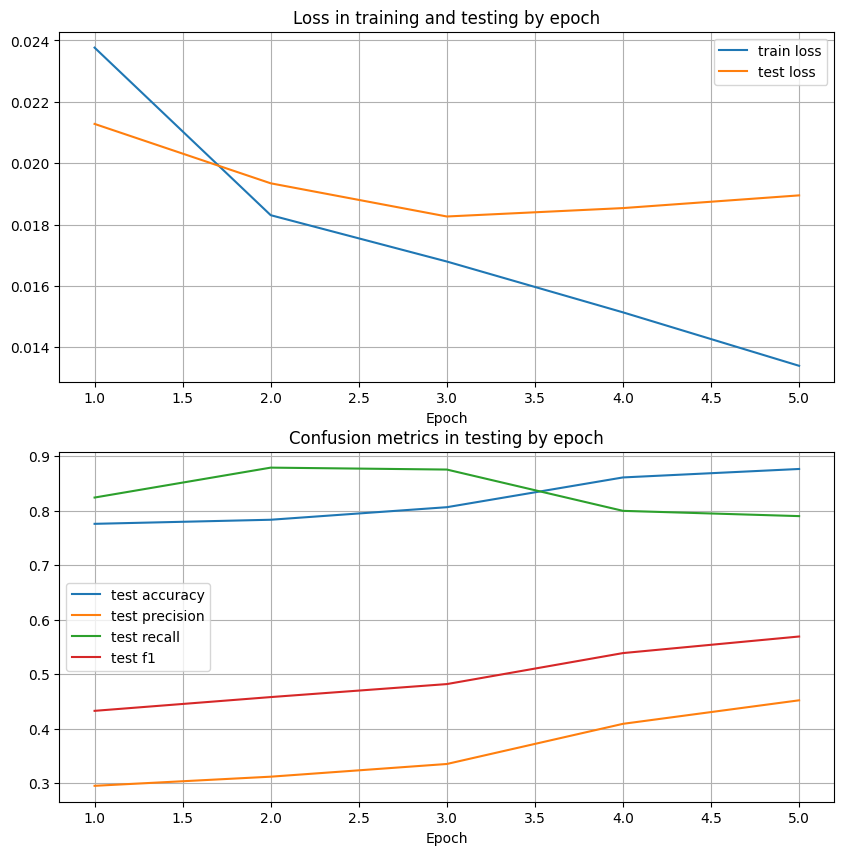

In [5]:

print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [6]:
torch.save(model, "model.pickle")